## Imports

In [1]:
import os
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from itertools import cycle
import torch 

import EWOthello.utils.plot_helpers as plt_utils
from EWOthello.mingpt.probe_model import BatteryProbeClassification
from EWOthello.data.othello import *
from EWOthello.mingpt.dataset import CharDataset 
from EWOthello.mingpt.model import GPT, GPTConfig, GPTforProbing, GPTforProbing_v2


/home/deanhazineh/anaconda3/envs/emergent_world/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## View Training Losses and Accuracy for New Probe Models vs Old Probes

In [2]:
datapath = "../EWOthello/ckpts/DeanModels/"

all_files = os.listdir(datapath)
new_board_probes = [file for file in all_files if file.startswith("linearProbe_Map_new")]
old_board_probes = [file for file in all_files if file.startswith("linearProbe_Map_old")]
new_board_probes.sort()
old_board_probes.sort()

print(old_board_probes)
print(new_board_probes)

['linearProbe_Map_old_8L8H_GPT_Layer6.ckpt', 'linearProbe_Map_old_8L8H_GPT_Layer6.pickle', 'linearProbe_Map_old_8L8H_GPT_Layer7.ckpt', 'linearProbe_Map_old_8L8H_GPT_Layer7.pickle', 'linearProbe_Map_old_8L8H_GPT_Layer8.ckpt', 'linearProbe_Map_old_8L8H_GPT_Layer8.pickle']
['linearProbe_Map_new_8L8H_GPT_Layer1.ckpt', 'linearProbe_Map_new_8L8H_GPT_Layer1.pickle', 'linearProbe_Map_new_8L8H_GPT_Layer2.ckpt', 'linearProbe_Map_new_8L8H_GPT_Layer2.pickle', 'linearProbe_Map_new_8L8H_GPT_Layer3.ckpt', 'linearProbe_Map_new_8L8H_GPT_Layer3.pickle', 'linearProbe_Map_new_8L8H_GPT_Layer4.ckpt', 'linearProbe_Map_new_8L8H_GPT_Layer4.pickle', 'linearProbe_Map_new_8L8H_GPT_Layer5.ckpt', 'linearProbe_Map_new_8L8H_GPT_Layer5.pickle', 'linearProbe_Map_new_8L8H_GPT_Layer6.ckpt', 'linearProbe_Map_new_8L8H_GPT_Layer6.pickle', 'linearProbe_Map_new_8L8H_GPT_Layer7.ckpt', 'linearProbe_Map_new_8L8H_GPT_Layer7.pickle', 'linearProbe_Map_new_8L8H_GPT_Layer8.ckpt', 'linearProbe_Map_new_8L8H_GPT_Layer8.pickle']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


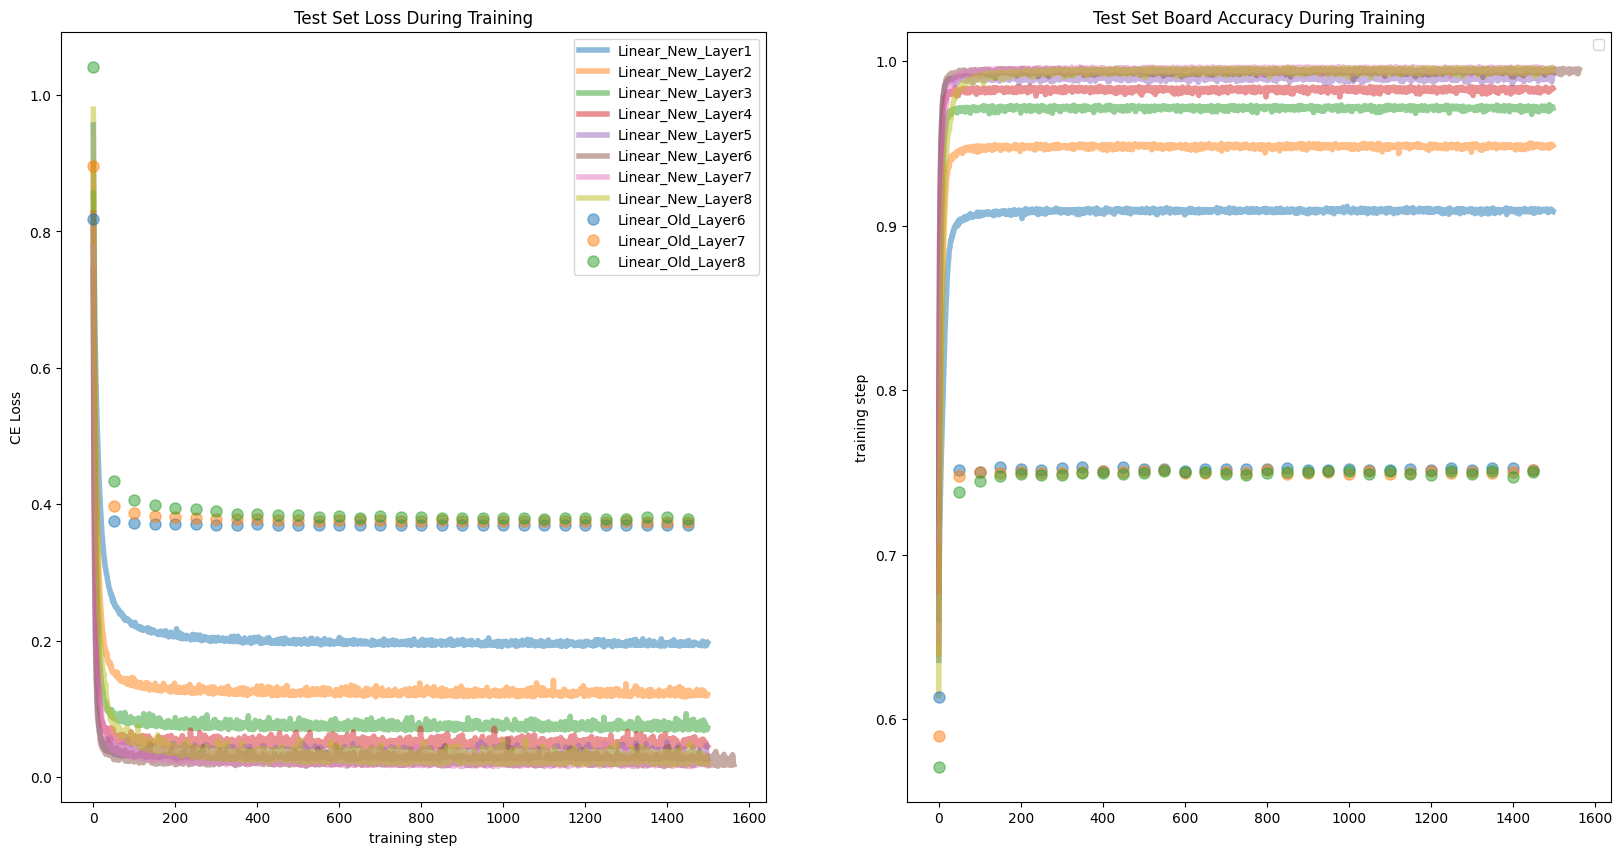

In [30]:
fig = plt.figure(figsize=(20, 10))
ax = plt_utils.addAxis(fig, 1, 2)
colors = cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan'])
for filename in new_board_probes:
    if filename.endswith(".pickle"):
        with open(datapath + filename, 'rb') as fhandle:
            data = pickle.load(fhandle)

        training_loss = data["training_loss"][:1563]
        testing_loss = data["testing_loss"][:1563]
        testing_board_acc = data["testing_board_acc"][:1563]

        use_color = color=next(colors)
        use_label = f"Linear_New_" + filename[-13:-7]
        #ax[0].plot(training_loss, '--', color=use_color)
        ax[0].plot(testing_loss, '-', color=use_color, alpha=0.5, linewidth=4, label=use_label)
        ax[1].plot(testing_board_acc, '-', color=use_color, alpha=0.5, linewidth=4)


colors = cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan'])
for filename in old_board_probes:
    if filename.endswith(".pickle"):
        with open(datapath + filename, 'rb') as fhandle:
            data = pickle.load(fhandle)

        training_loss = data["training_loss"][:1563]
        testing_loss = data["testing_loss"][:1563]
        testing_board_acc = data["testing_board_acc"][:1563]
        
        num_elem = len(testing_loss)    
        skip=50
        use_color = color=next(colors)
        use_label = f"Linear_Old_" + filename[-13:-7]
        #ax[0].plot(training_loss, '*', color=use_color)
        ax[0].plot(np.arange(0,num_elem, skip), testing_loss[::skip], 'o', color=use_color, alpha=0.5, markersize=8, label=use_label)
        ax[1].plot(np.arange(0,num_elem, skip),testing_board_acc[::skip], 'o', color=use_color, alpha=0.5, markersize=8)

ax[0].set_title("Test Set Loss During Training")
ax[1].set_title("Test Set Board Accuracy During Training")
ax[0].set_ylabel("CE Loss")
ax[1].set_ylabel("Avg. Board Classification")
ax[0].set_xlabel("training step")
ax[1].set_ylabel("training step")
ax[0].legend()
ax[1].legend()

## Visualize the Probe Projections in action

In [31]:
othello = get(ood_num=-1, data_root=None, num_preload=1) # 11 corresponds to over 1 million games
game_dataset = CharDataset(othello) 

Max num files: 230; Use_num: 1
['gen10e5__20220324_165952.pickle']


Mem Used: 0.6814 GB: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Deduplicating...
Deduplicating finished with 99999 games left
Using 20 million for training, 0 for validation
Dataset created has 99999 sequences, 61 unique words.


In [32]:
mconf = GPTConfig(game_dataset.vocab_size, game_dataset.block_size, n_layer=8, n_head=8, n_embd=512)
GPT_probe = GPTforProbing(mconf, probe_layer=6)
GPT_probe.load_state_dict(torch.load("../EWOthello/ckpts/gpt_synthetic.ckpt"))
GPT_probe.eval()
device = torch.cuda.current_device()
GPT_probe = GPT_probe.to(device)

# Get a single full-game sequence data from the game_dataset (index=#)
index = 5000
x, _ = game_dataset[index]
tbf = [game_dataset.itos[_] for _ in x.tolist()]
valid_until = tbf.index(-100) if -100 in tbf else 999

# Get the board state vectors
property_modifier = np.concatenate([np.ones((1, 64)) * (-1) ** i for i in range(59)], axis=0)
a = OthelloBoardState()
board_state = a.get_gt(tbf[:valid_until], "get_state")
board_state = (np.array(board_state) - 1.0) * property_modifier[:valid_until, :] + 1.0

# Get the activation vectors
act = GPT_probe(x[None, :].to(device))[0, :valid_until, :].detach().cpu()

Text(0, 0.5, 'Reconst. Board from Activation')

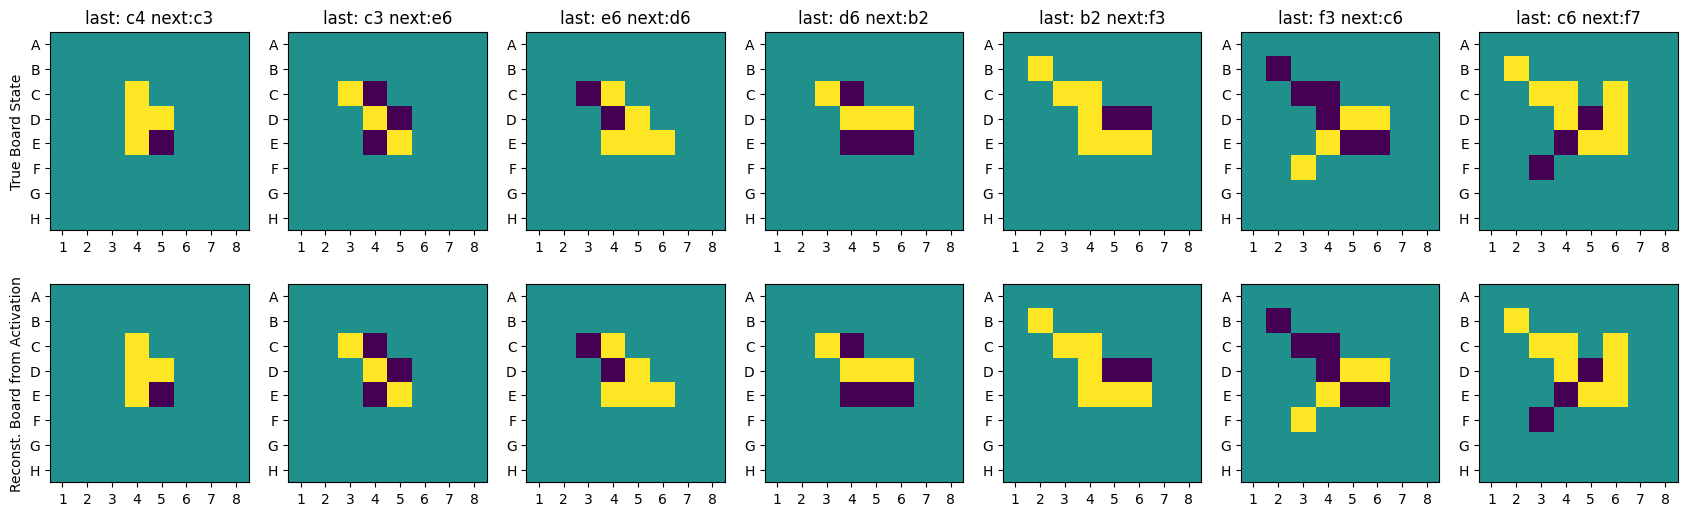

In [33]:
load_proj_ckpt = "../EWOthello/ckpts/DeanModels/linearProbe_Map_new_8L8H_GPT_Layer6.ckpt"
data = torch.load(load_proj_ckpt)
proj_matrix = data["proj.weight"].detach().cpu()
proj_bias = data["proj.bias"].detach().cpu()
pred_board = torch.matmul(act, proj_matrix.T) + proj_bias
pred_board = torch.argmax(pred_board.reshape(-1, 64, 3), -1, keepdim=False)

num_moves = 7
game_moves = plt_utils.seq_to_boardCoord(tbf[:num_moves+1])
fig = plt.figure(figsize=(3*num_moves, 6))
ax = plt_utils.addAxis(fig, 2, num_moves)
for i in range(num_moves):
    ax[i].imshow(board_state[i].reshape(8,8))
    ax[i].set_title(f"last: {game_moves[i]} next:{game_moves[i+1]}")
    ax[i+num_moves].imshow(pred_board[i].reshape(8,8))
plt_utils.format_ax_boardImage(ax)
ax[0].set_ylabel("True Board State")
ax[num_moves].set_ylabel("Reconst. Board from Activation")

Text(0, 0.5, "Proj. Logits 'Your Piece'")

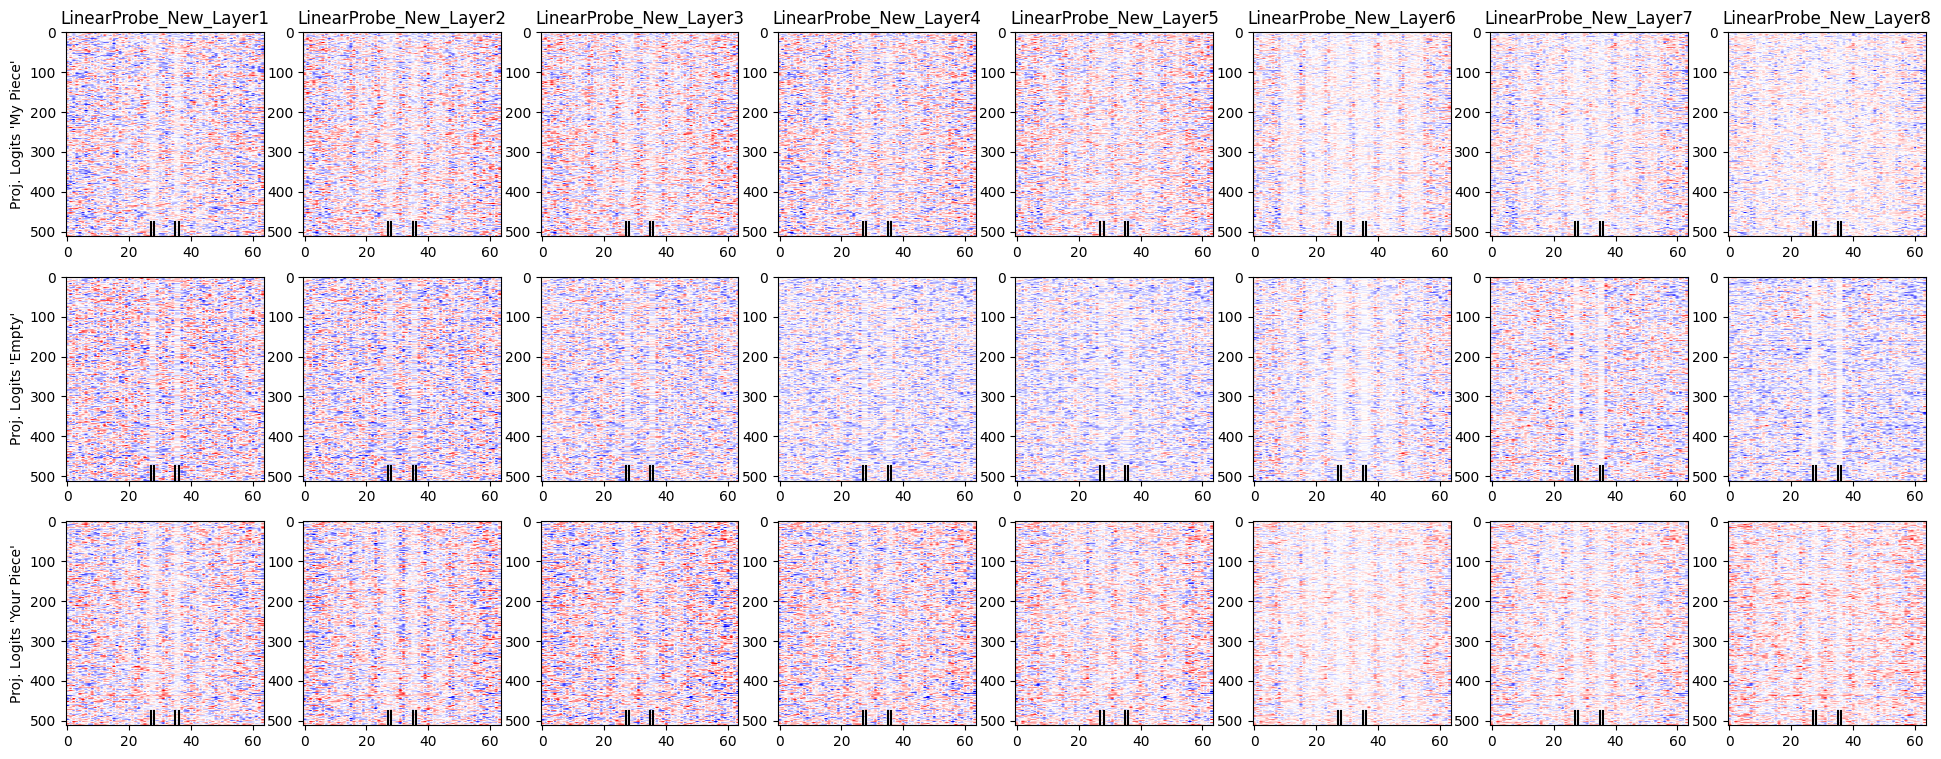

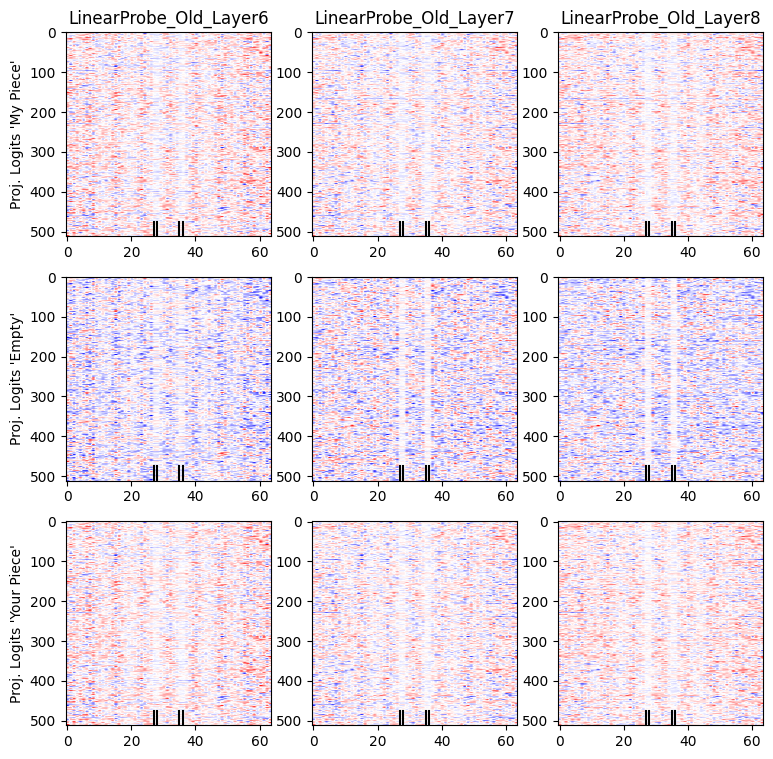

In [34]:
# Visualize the projection matrix for the new probes
starting_tiles = [27, 28, 35, 36]

num_layers = 8
fig = plt.figure(figsize=(num_layers*3, 9))
ax = plt_utils.addAxis(fig, 3, num_layers)
iter = 0
classification_map = []
for filename in new_board_probes:
    if filename.endswith(".ckpt"):
        data = torch.load(datapath + filename)
        proj_matrix = data["proj.weight"].detach().cpu().T.reshape(-1, 64, 3)
        proj_bias = data["proj.bias"].detach().cpu().reshape(64, 3)
        use_name = f"LinearProbe_New_{filename[-11:-5]}"
        for i in range(3): # Plot each output prob as row
            ax[iter + num_layers*i].imshow(proj_matrix[:,:,i], norm=TwoSlopeNorm(0), cmap="seismic", aspect="auto")
            ax[iter + num_layers*i].set_ylabel("")
            for ref_tile in starting_tiles:
                ax[iter + num_layers*i].plot([ref_tile, ref_tile], [475, 511], 'k-')
        ax[iter].set_title(use_name)
        iter +=1
ax[0].set_ylabel("Proj. Logits 'My Piece'")
ax[num_layers].set_ylabel("Proj. Logits 'Empty'")
ax[2*num_layers].set_ylabel("Proj. Logits 'Your Piece'")



### Repeat the plot for old model
num_layers = 3
fig = plt.figure(figsize=(num_layers*3, 9))
ax = plt_utils.addAxis(fig, 3, num_layers)
iter = 0
classification_map = []
for filename in old_board_probes:
    if filename.endswith(".ckpt"):
        data = torch.load(datapath + filename)
        proj_matrix = data["proj.weight"].detach().cpu().T.reshape(-1, 64, 3)
        proj_bias = data["proj.bias"].detach().cpu().reshape(64, 3)
        use_name = f"LinearProbe_Old_{filename[-11:-5]}"
        for i in range(3): # Plot each output prob as row
            ax[iter + num_layers*i].imshow(proj_matrix[:,:,i], norm=TwoSlopeNorm(0), cmap="seismic", aspect="auto")
            ax[iter + num_layers*i].set_ylabel("")
            for ref_tile in starting_tiles:
                ax[iter + num_layers*i].plot([ref_tile, ref_tile], [475, 511], 'k-')
        ax[iter].set_title(use_name)
        iter +=1
ax[0].set_ylabel("Proj. Logits 'My Piece'")
ax[num_layers].set_ylabel("Proj. Logits 'Empty'")
ax[2*num_layers].set_ylabel("Proj. Logits 'Your Piece'")

In [9]:
plt_utils.seq_to_boardCoord([27, 28, 35, 36])

['d4', 'd5', 'e4', 'e5']